# Modeling Earth's Magnetic Field

This notebook explores the PySPEDAS routines for working with magnetic field models, using the PySPEDAS interface to the PyHC geopack package.

- https://github.com/heliophysicsPy/summer-school-24/blob/main/pyspedas-tutorial/Magnetic_Field_Modeling.ipynb

As usual, we'll import pyspedas, pytplot, and pytplot.tplot.   The interface wrapper routines to the geopack library are in the pyspedas.geopack module.  

In [ ]:
import pyspedas
import pytplot
from pytplot import tplot
from pyspedas.geopack import tt89

Load IGRF coefficients ...


25-Dec-24 21:53:41: Downloading https://themis.ssl.berkeley.edu/data/themis/tha/l1/state/2007/tha_l1_state_20070323.cdf to themis_data/tha/l1/state/2007/tha_l1_state_20070323.cdf
25-Dec-24 21:53:42: Download complete: themis_data/tha/l1/state/2007/tha_l1_state_20070323.cdf


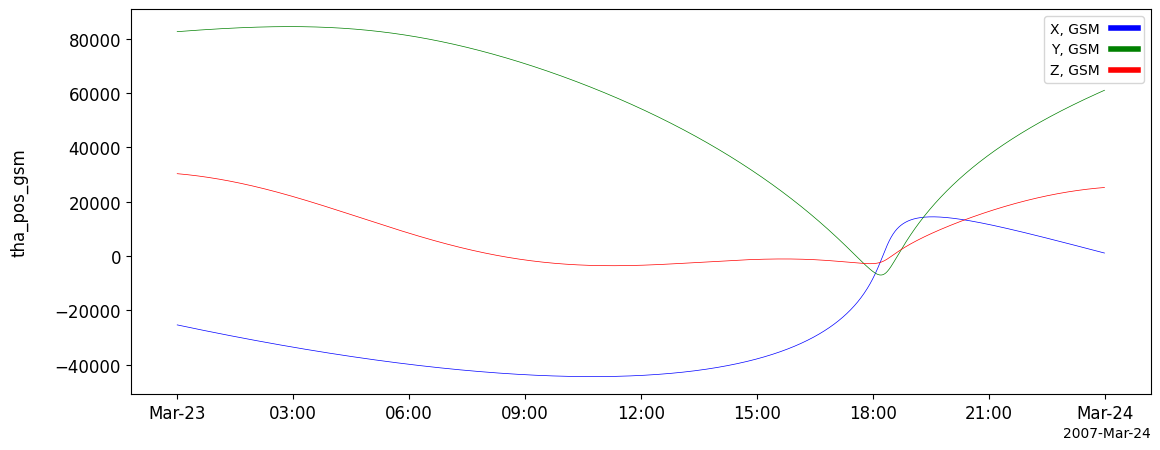

In [ ]:
# Set a time range and load some THEMIS-A position data to use when generating the field models

trange = ['2007-03-23', '2007-03-24']
pyspedas.themis.state(probe='a', trange=trange, varnames=["tha_pos_gsm"])
tplot('tha_pos_gsm')

# Tsyganenko 89 (T89) model

- https://pyspedas.readthedocs.io/en/latest/geopack.html

In [ ]:
# Generate the T89 model with default value for the Kp parameter

tt89('tha_pos_gsm')

'tha_pos_gsm_bt89'

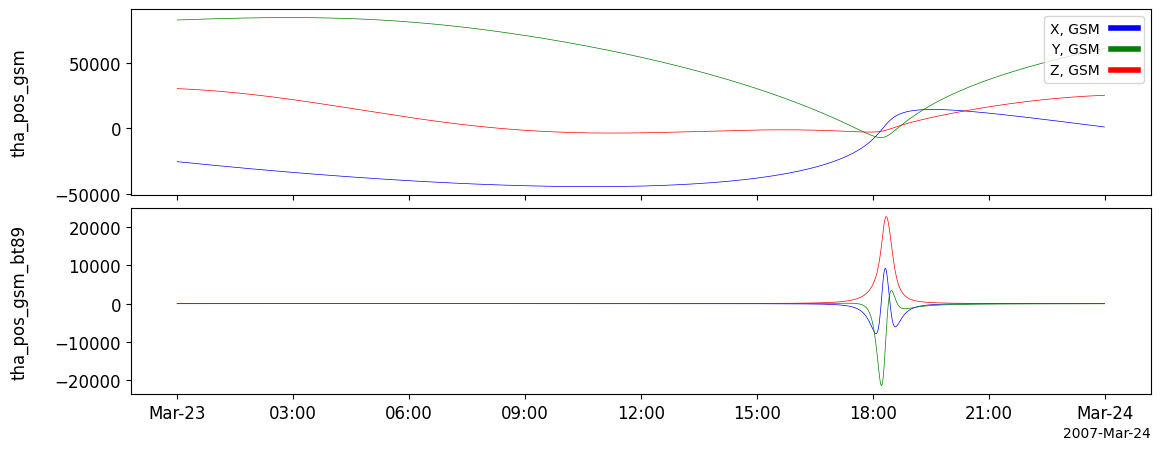

In [ ]:
# Output will have a _bt89 suffix

tplot(['tha_pos_gsm','tha_pos_gsm_bt89'])

# IGRF-only model

Internally, many of the geopack routines operate by generating a dipole model with the standard IGRF coefficients, then adding in some model-specific perturbations.

You can get just the IGRF part by specifying `igrf_only=True` in `tt89()`

In [ ]:
tt89('tha_pos_gsm', igrf_only=True, suffix='_igrf') # The default _bt89 suffix also gets added

'tha_pos_gsm_bt89_igrf'

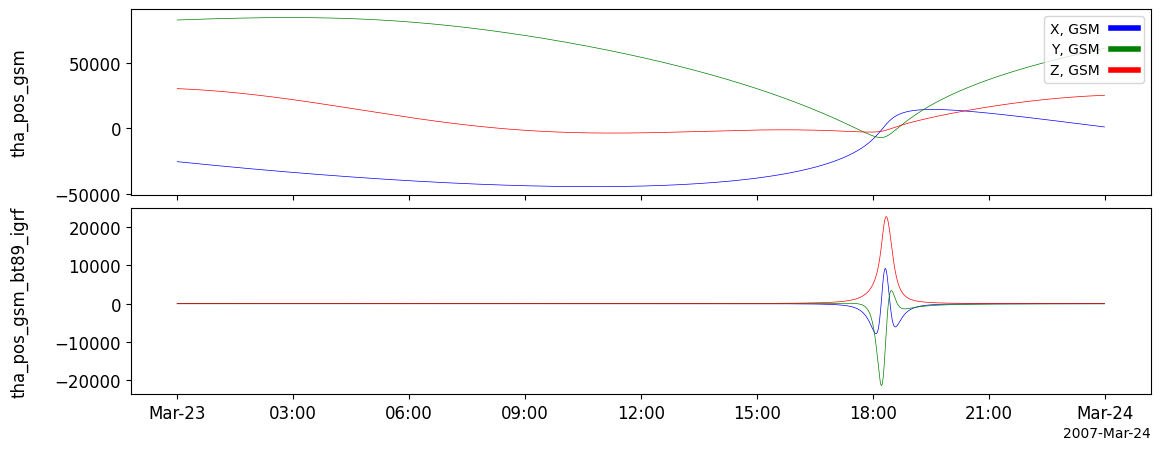

In [ ]:
tplot(['tha_pos_gsm', 'tha_pos_gsm_bt89_igrf'])

Subtract the IGRF-only field from the T89 field to see the T89 perturbations

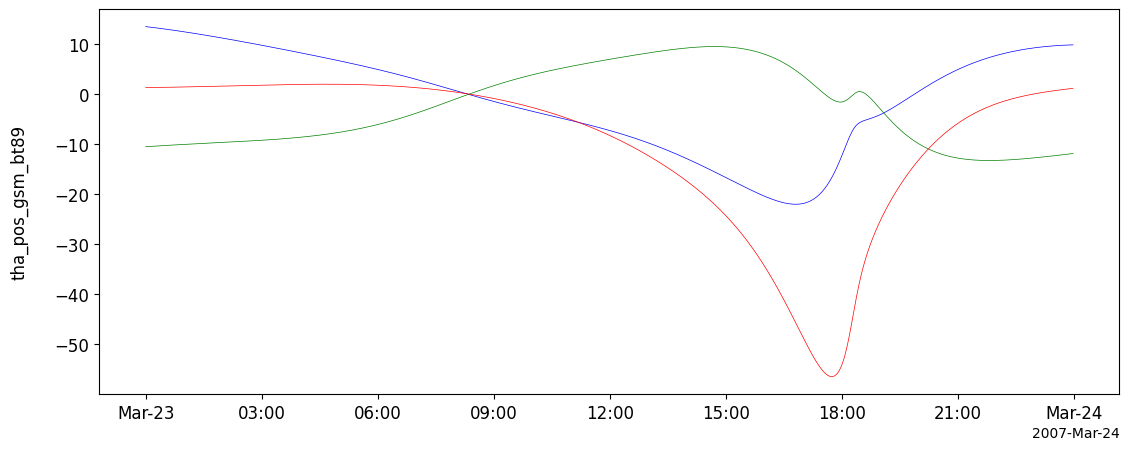

In [ ]:
pytplot.subtract('tha_pos_gsm_bt89', 'tha_pos_gsm_bt89_igrf', newname='bt89_perturbations')
tplot('bt89_perturbations')

Pass a specific iopt parameter value to the T89 model.  

iopt=7 corresponds to Kp > 6

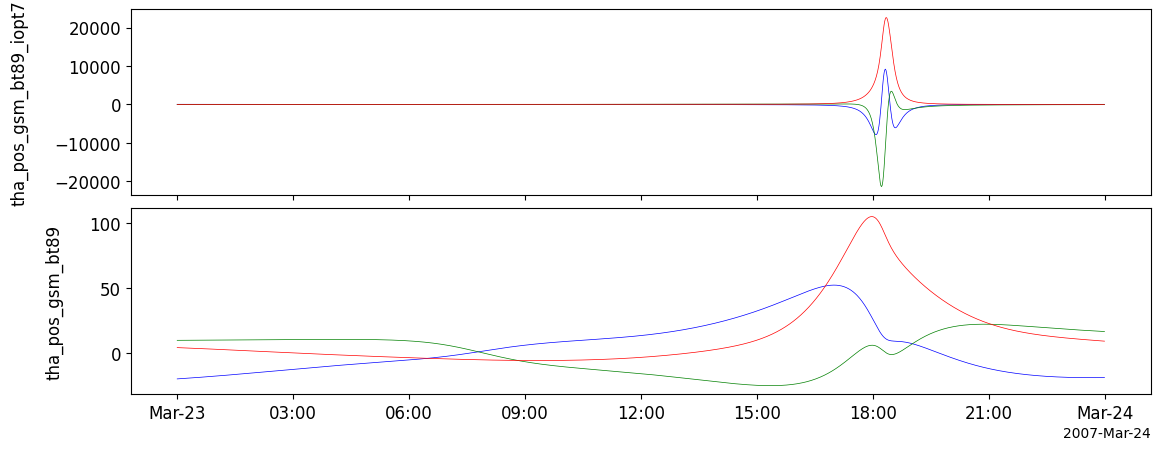

In [ ]:
tt89('tha_pos_gsm', iopt=7, suffix='_iopt7')

# And let's take the difference from the model with the default iopt
pytplot.subtract('tha_pos_gsm_bt89', 'tha_pos_gsm_bt89_iopt7', 'iopt_diff')
tplot(['tha_pos_gsm_bt89_iopt7','iopt_diff'])

# Tsyganenko 96 'T96' model

This model is a bit more complex than T89, and takes more input parameters.  The `tt96()` routine expects the model parameters to be supplied as a tplot variable, with the same cadence as the input times/positions, with the data values being 10-element 'parmod' arrays with the input parameters packed in a certain order (after the original FORTRAN GEOPACK library convention).  We'll use a helper routine to load the Dst storm-time index from the Kyoto World Data Center, and the other parameters from the OMNI data set, and pack them into a parmod tplot variable.

In [ ]:
from pyspedas.geopack import get_tsy_params
from pytplot import join_vec, time_double

def get_params(trange):
    support_trange = [time_double(trange[0])-60*60*24, 
                      time_double(trange[1])+60*60*24]
    pyspedas.kyoto.dst(trange=support_trange)
    pyspedas.omni.data(trange=support_trange)
    join_vec(['BX_GSE', 'BY_GSM', 'BZ_GSM']) # Not a typo!  OMNI doesn't return a BX_GSM variable!  (We don't use that component anyway)
    return get_tsy_params('kyoto_dst',
                    'BX_GSE-BY_GSM-BZ_GSM_joined',
                    'proton_density',
                    'flow_speed',
                    model='t96',
                    pressure_tvar='Pressure',
                    g_variables=None,
                    speed=True)

parmod = get_params(trange)
print(parmod) # in this case, t96_par

25-Dec-24 21:57:24: Downloading http://wdc.kugi.kyoto-u.ac.jp/dst_final/200703/index.html to pydata/geom_indices/kyoto/dst_final/200703/index.html
25-Dec-24 21:57:24: Download complete: pydata/geom_indices/kyoto/dst_final/200703/index.html
25-Dec-24 21:57:24: 
            ******************************
            The DST data are provided by the World Data Center for Geomagnetism, Kyoto, and
            are not for redistribution (http://wdc.kugi.kyoto-u.ac.jp/). Furthermore, we thank
            the geomagnetic observatories (Kakioka [JMA], Honolulu and San Juan [USGS], Hermanus
            [RSA], Alibag [IIG]), NiCT, INTERMAGNET, and many others for their cooperation to
            make the Dst index available.
            ******************************
        
25-Dec-24 21:57:24: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_1min/2007/
25-Dec-24 21:57:25: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_1min/2007/omni_hro2

t96_par


Now we're ready to generate T96 model data.

25-Dec-24 21:57:54: tinterpol (linear) was applied to: parmod_interp


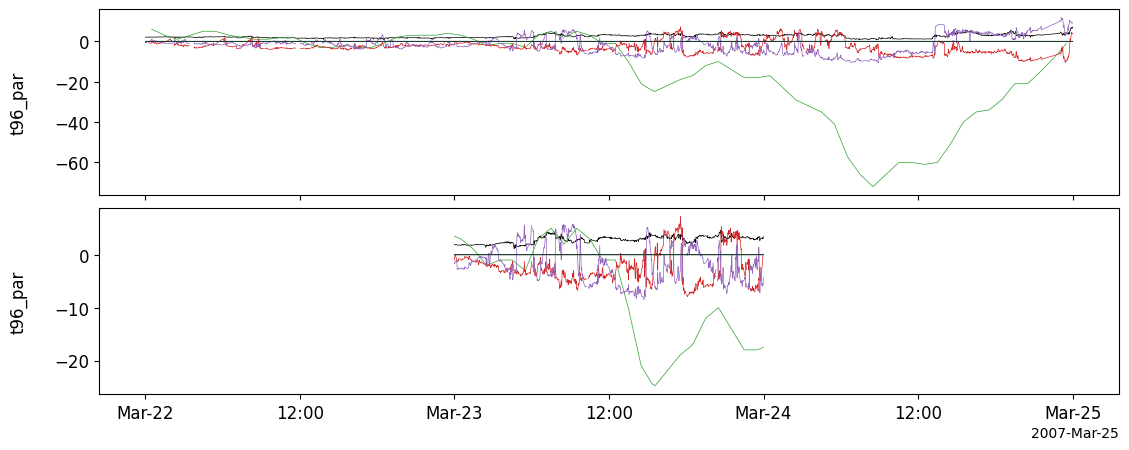

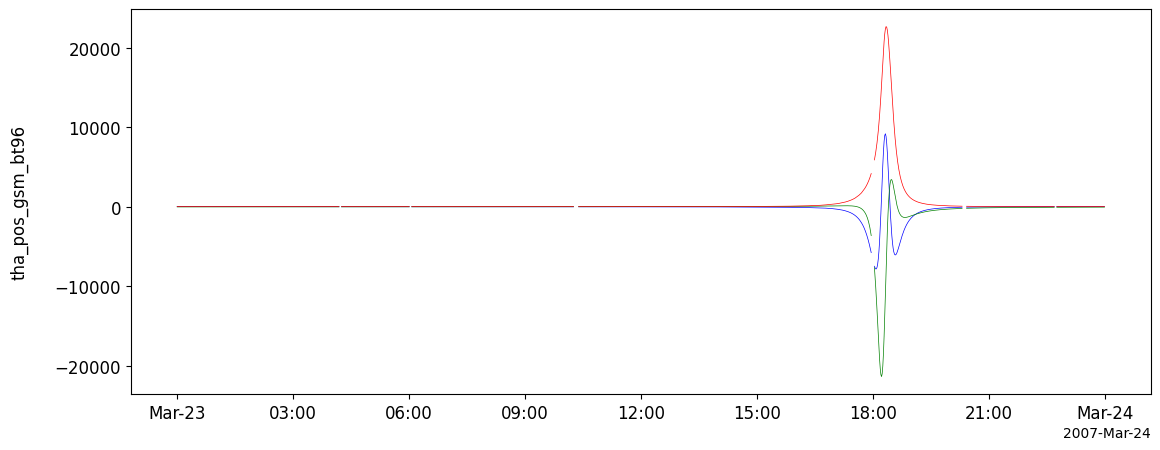

In [ ]:
from pyspedas.geopack import tt96

# The model parameters should be supplied at the same timestamps as the input positions, so we do some interpolation:
pyspedas.tinterpol(parmod,'tha_pos_gsm',newname='parmod_interp')

# The original parmod had extra padding around the time range of interest, and
# there's no guarantee that the timestamps lined up as needed
tplot([parmod,'parmod_interp'])
tt96('tha_pos_gsm', parmod='parmod_interp')
tplot('tha_pos_gsm_bt96')

Finally, we'll look at the difference between the T89 and T96 model fields.

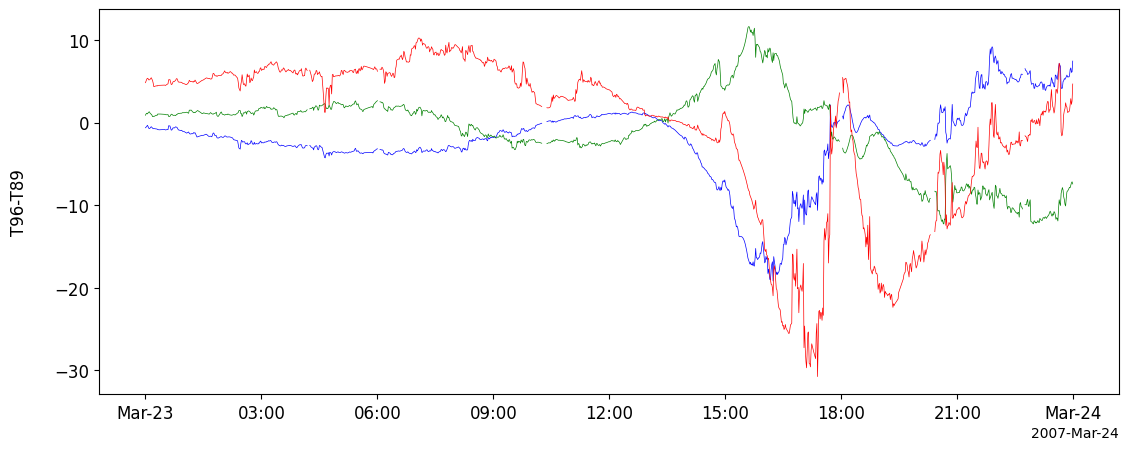

In [ ]:
pytplot.subtract('tha_pos_gsm_bt96', 'tha_pos_gsm_bt89', newname='t96_t89_diff')
pytplot.options('t96_t89_diff','ytitle','T96-T89')
tplot('t96_t89_diff')